# Fintech Stock Price Assignment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-09-13,15400,15519,15320,15400,234851
2010-09-14,15500,15620,15200,15200,371530
2010-09-15,15260,15340,15020,15140,389289
2010-09-16,15080,15260,15080,15140,234815
2010-09-17,15240,15560,15159,15460,447649


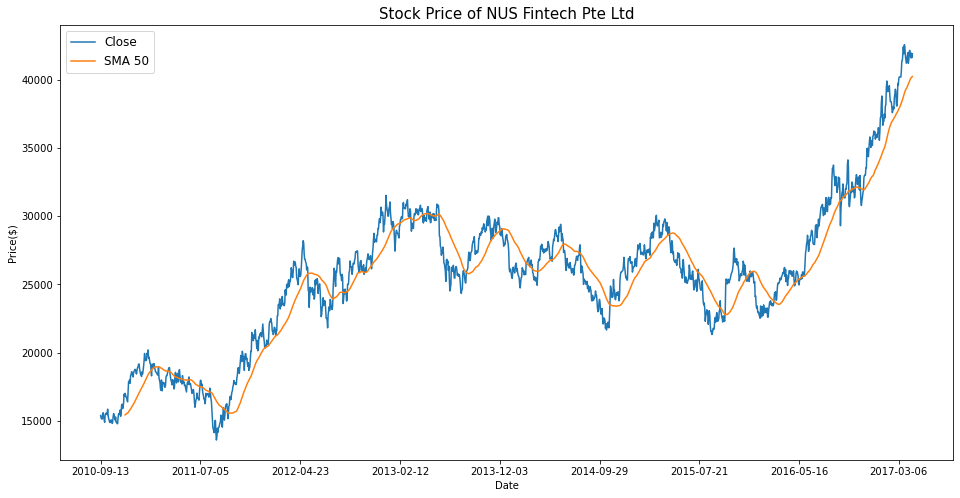

In [3]:
df['Close'].plot(figsize=(16,8))
df['Close'].rolling(50).mean().plot(label='SMA 50')
plt.title('Stock Price of NUS Fintech Pte Ltd', fontsize=15)
plt.ylabel('Price($)')
plt.xlabel('Date')
plt.legend(fontsize=12)

## Autoregressive Model

Test RMSE: 364.646


C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


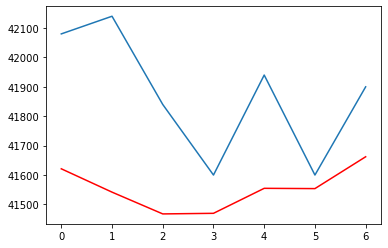

In [4]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt


# split dataset
X = df['Close'].values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Moving Average Model

Test RMSE: 545.681


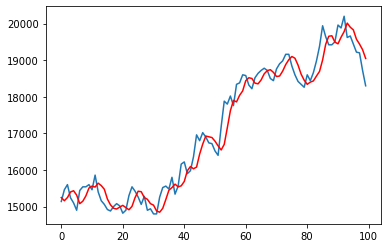

In [5]:
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# prepare
X = df['Close'].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='red')
pyplot.show()

## ARIMA Model

In [6]:
X = df['Close']
train, test = X[:len(X)-7], X[len(X)-7:]

<Figure size 432x288 with 0 Axes>

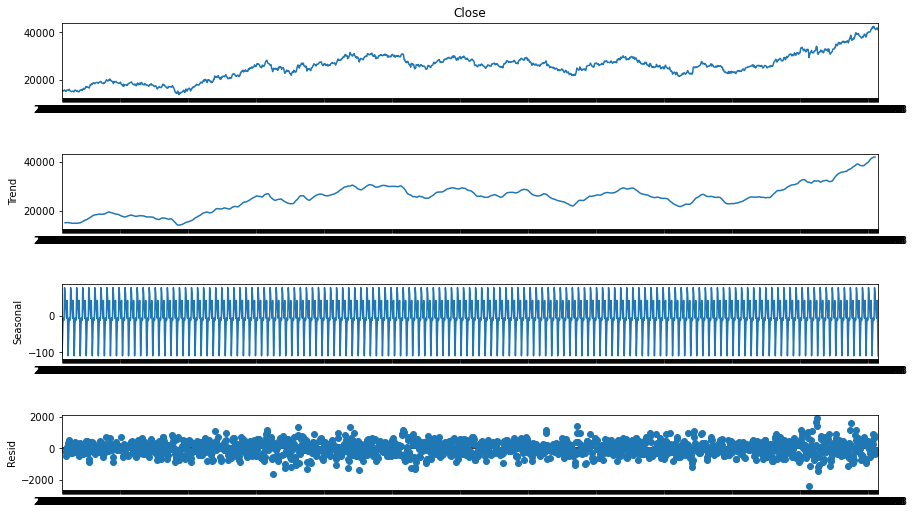

In [7]:
# decomposing model into trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train, period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [8]:
# function to print adfuller test results  
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    print('\n')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis: Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis: Time series has a unit root, indicating it is non-stationary")

In [9]:
# checking stationarity of timeseries data
adf_check(train)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.5310332513849008
p-value : 0.8858169813515403
#Lags Used : 3
Number of Observations Used : 1617


Weak evidence against null hypothesis: Time series has a unit root, indicating it is non-stationary


In [10]:
# differencing non-stationary timeseries data
df['Close First Difference'] = train - train.shift(1)
df['Close First Difference'].head()

Date
2010-09-13      NaN
2010-09-14   -200.0
2010-09-15    -60.0
2010-09-16      0.0
2010-09-17    320.0
Name: Close First Difference, dtype: float64

In [11]:
# checking stationarity of first-order differenced timeseries data
adf_check(df['Close First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -26.353791861250887
p-value : 0.0
#Lags Used : 2
Number of Observations Used : 1617


Strong evidence against the null hypothesis: Data has no unit root and is stationary


<AxesSubplot:xlabel='Date'>

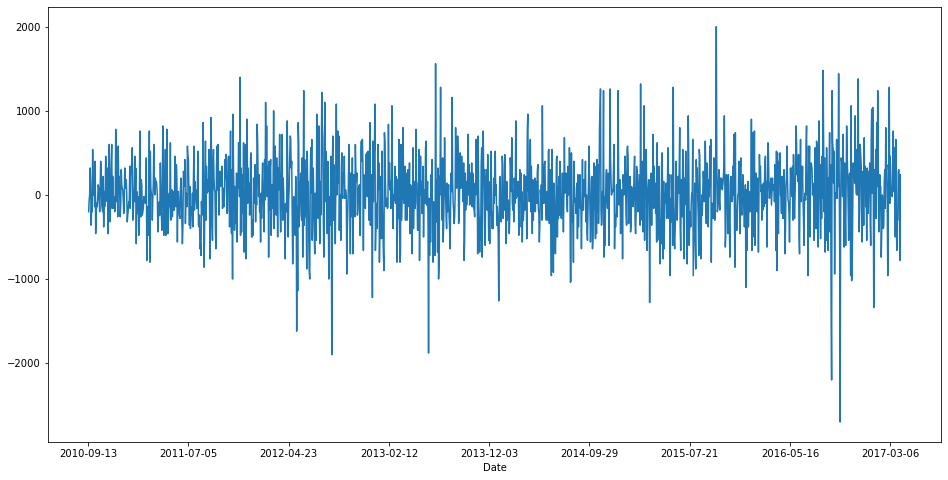

In [12]:
# plotting first-order differenced timeseries data
df['Close First Difference'].plot(figsize=(16,8))
# white noise-like pattern concludes it is indeed stationary

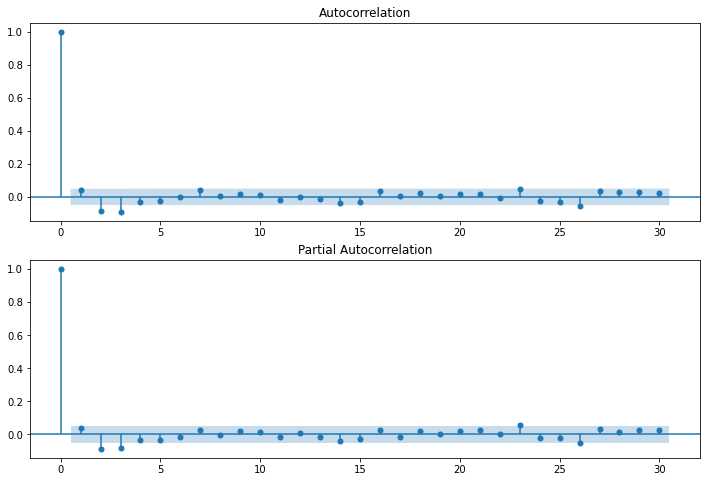

In [13]:
# plotting autocorrelation and partial autocorrelation plots
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close First Difference'].dropna().iloc[13:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close First Difference'].dropna().iloc[13:], lags=30, ax=ax2)
# the plots show no sign of autoregression or moving average

In [14]:
# creating SARIMAX model
model = sm.tsa.statespace.SARIMAX(train, order=(0,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1621
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood              -12610.580
Date:                            Mon, 04 Oct 2021   AIC                          25223.160
Time:                                    02:03:17   BIC                          25228.543
Sample:                                         0   HQIC                         25225.159
                                           - 1621                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.778e+05   9897.299     38.172      0.000    3.58e+05    3.97e+05
Ljung-Box (L1) (Q):                

C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
# predicting forecasted prices
fc = pd.Series(results.forecast(7, alpha=0.05))
fc.index = pd.Series(pd.date_range(start = train.index[-1], periods=7+1, freq='B')[1:])
fc.head()

C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2017-04-04    42000.0
2017-04-05    41500.0
2017-04-06    42160.0
2017-04-07    42060.0
2017-04-10    41400.0
Name: predicted_mean, dtype: float64

In [16]:
# confidence intervals of predicted forecast
n = len(train)
prediction = results.get_prediction(start=n+1, end=n+7)
prediction_ci = prediction.conf_int()
prediction_ci.index = pd.Series(pd.date_range(start = train.index[-1], periods=7+1, freq='B')[1:])
print(prediction_ci.head())

             lower Close   upper Close
2017-04-04  39796.298967  43203.701033
2017-04-05  40073.400897  44246.599103
2017-04-06  39650.602893  44469.397107
2017-04-07  38706.212142  44093.787858
2017-04-10  38149.103250  44050.896750


C:\Users\brian\anaconda3\envs\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


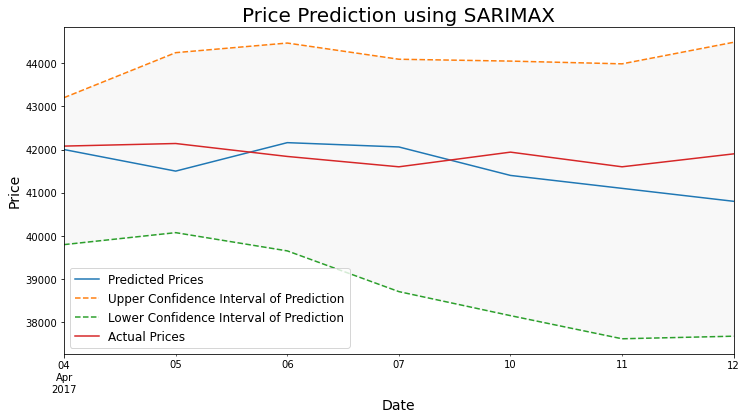

In [17]:
plt.figure(figsize=(12, 6))

ax = fc.plot(style='-', label='Predicted Prices')
prediction_ci['upper Close'].plot(ax=ax, style='--', label='Upper Confidence Interval of Prediction')
prediction_ci['lower Close'].plot(ax=ax, style='--', label='Lower Confidence Interval of Prediction')
test.index=fc.index
test.plot(ax=ax, label='Actual Prices')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci, color='grey', alpha=0.05)

ax.set_xlabel('Date', size=14)
ax.set_ylabel('Price', size=14)
ax.legend(fontsize=12)
ax.set_title('Price Prediction using SARIMAX', size=20)

plt.show()

In [18]:
# evaluation of prediction with rmse
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test, fc))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 595.411


## Chosen Model for Prediction

Since the Autoregressive Model has the lowest RMSE test score, we will use this model as our model for prediction.

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train = df['Close']
result = []

for i in range(1086):

    model = AutoReg(train.values, lags=32)
    model_fit = model.fit()

    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
    train.append(pd.Series(predictions[0]))
    result.append(predictions[0])
    train = train[1:]

result = pd.DataFrame(result, columns=['Predicted'])
date_df = pd.read_csv('sample_submission.csv')
result.index = date_df['Date']
result.to_csv('Submission.csv')

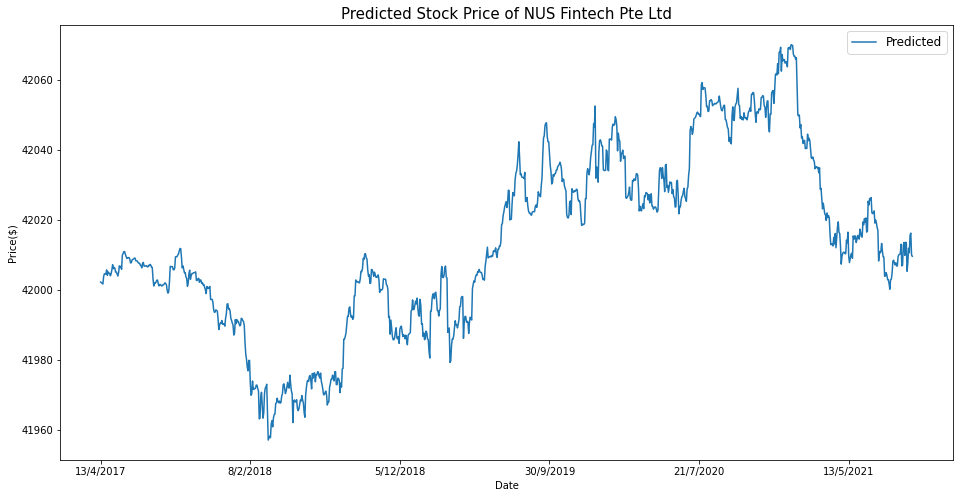

In [21]:
result.plot(figsize=(16,8))
plt.title('Predicted Stock Price of NUS Fintech Pte Ltd', fontsize=15)
plt.ylabel('Price($)')
plt.xlabel('Date')
plt.legend(fontsize=12)